In [2]:
from sea_breeze.load_model_data import *
from sea_breeze.sea_breeze_funcs import single_col_circulation, load_angle_ds, kinematic_frontogenesis, vert_mean_wind, weighted_vert_mean_wind
from sea_breeze.coastline_funcs import latlon_dist
import numpy as np
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import hvplot.xarray
import scipy
import tqdm

In [3]:
from climtas.nci import GadiClient
client = GadiClient()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45215 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45215/status,
Dashboard: /proxy/45215/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33895,Workers: 4
Dashboard: /proxy/45215/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:42935,Total threads: 1
Dashboard: /proxy/36413/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33349,


In [4]:
lat_slice=slice(-45,-30)
lon_slice=slice(140,155)
t1="2024-01-29 00:00"
t2="2024-01-29 06:00"

In [5]:
domain_id = "AUS-11"
freq = "1hr"
vert_coord = "pressure"
barra_var_names = ["ts","tas"]
barrar_vars = load_barra_variable(barra_var_names, t1, t2, domain_id, freq, lat_slice, lon_slice, chunks={"lat":-1,"lon":-1})
orog, lsm = load_barra_static(domain_id,lon_slice,lat_slice)
barrar_angles = load_angle_ds("/g/data/gb02/ab4502/coastline_data/barra_r_angles_v2.nc",lat_slice,lon_slice)

In [6]:
from sea_breeze.sea_breeze_funcs import land_sea_temperature_grad, land_sea_temperature_diff

100%|██████████| 137/137 [00:01<00:00, 70.64it/s]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


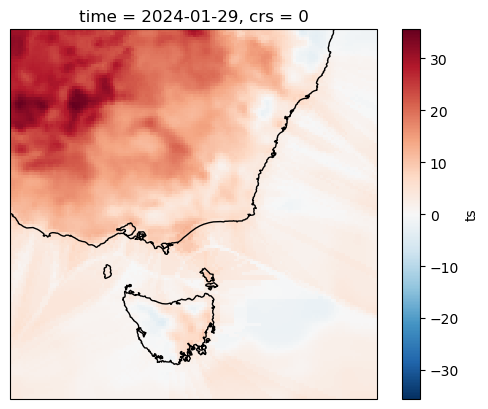

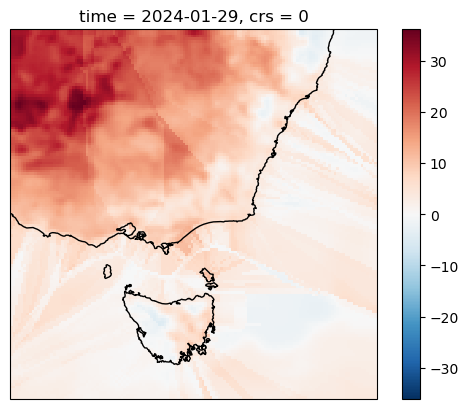

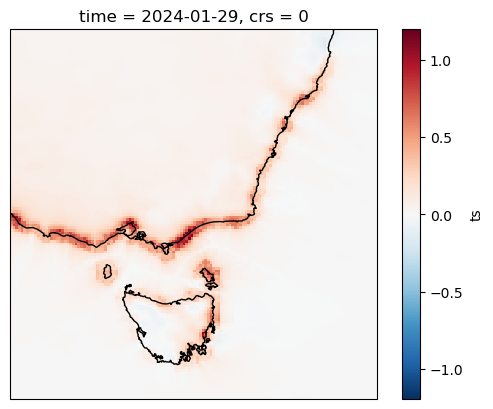

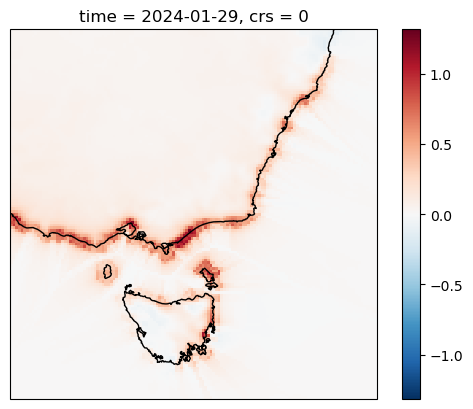

In [9]:
t="2024-01-29 00:00"
plt.figure(); ax=plt.axes(projection=ccrs.PlateCarree()); land_sea_temperature_diff(barrar_vars["ts"]["ts"], lsm, 10, weighting="none", sigma=0.3).sel(time=t).plot(); ax.coastlines()

plt.figure(); ax=plt.axes(projection=ccrs.PlateCarree()); land_sea_temperature_diff(barrar_vars["ts"]["ts"], lsm, 10, weighting="gaussian", sigma=0.1).sel(time=t).plot(); ax.coastlines()

plt.figure(); ax=plt.axes(projection=ccrs.PlateCarree()); land_sea_temperature_grad(barrar_vars["ts"]["ts"], lsm, 10, barrar_angles, weighting="none", sigma=0.1).sel(time=t).plot(); ax.coastlines()

plt.figure(); ax=plt.axes(projection=ccrs.PlateCarree()); land_sea_temperature_grad(barrar_vars["ts"]["ts"], lsm, 10, barrar_angles, weighting="gaussian", sigma=0.1).sel(time=t).plot(); ax.coastlines()

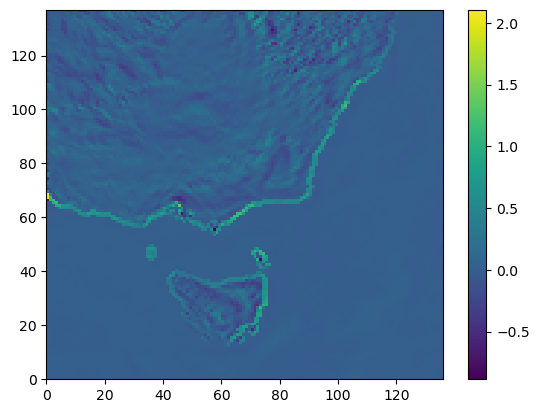

In [6]:
#Method 0: Lets look at the gradient in cross-shore surface temperature

theta=barrar_angles.angle_interp 

#Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
rotated_angle=(((theta)%360-90)%360) + 90   

#Define normal angle vectors, pointing onshore
cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]

#Calculate cross-shore surface temperature gradient and plot
dt_dx, dt_dy = mpcalc.geospatial_gradient(barrar_vars["ts"]["ts"], x_dim=barrar_vars["ts"]["ts"].get_axis_num("lon"), y_dim=barrar_vars["ts"]["ts"].get_axis_num("lat"))
dt_dc = (dt_dx*cx.values) + (dt_dy*cy.values)

plt.pcolormesh(dt_dc[3].to("K/km")); plt.colorbar()

In [7]:
#Now for the next two methods we need to define land and sea nearest neighbour lookup for all points

lat = barrar_angles.lat.values
lon = barrar_angles.lon.values
xx,yy = np.meshgrid(lon,lat)

#Land NN
land_x, land_y = np.where(lsm==1)
land_lon = lon[land_y]
land_lat = lat[land_x]

land_X = np.array([land_lat, land_lon]).T
land_kdt = scipy.spatial.KDTree(land_X)

#Sea NN
sea_x, sea_y = np.where(lsm==0)
sea_lon = lon[sea_y]
sea_lat = lat[sea_x]

sea_X = np.array([sea_lat, sea_lon]).T
sea_kdt = scipy.spatial.KDTree(sea_X)

In [32]:
#Now look up the N closest land/sea points and store in an extra third dimension "points"

N = 20

#For land NN
_,land_ind = land_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, N)

target_lon_land = land_lon[land_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lat_land = land_lat[land_ind.reshape((lat.shape[0],lon.shape[0],-1))]

target_lon_land = xr.DataArray(target_lon_land,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})
target_lat_land = xr.DataArray(target_lat_land,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})

#For sea NN
_,sea_ind = sea_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, N)

target_lon_sea = sea_lon[sea_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lat_sea = sea_lat[sea_ind.reshape((lat.shape[0],lon.shape[0],-1))]

target_lon_sea = xr.DataArray(target_lon_sea,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})
target_lat_sea = xr.DataArray(target_lat_sea,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})

2024-10-30 11:37:29,307 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-10-30 11:37:30,495 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-10-30 11:37:31,129 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


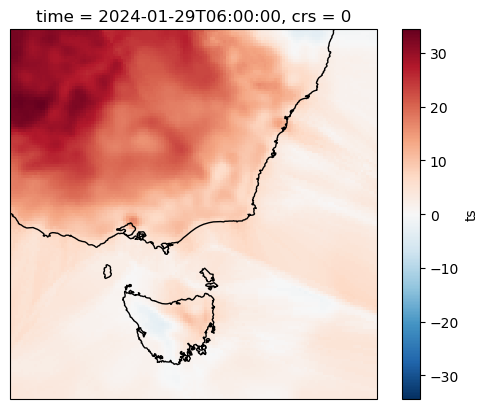

In [33]:
#Method 1: for each point calculate the mean of the closest N land and N sea points, and take the diff

land_minus_sea = (barrar_vars["ts"]["ts"].sel(lon=target_lon_land,lat=target_lat_land).mean("points").assign_coords({"lat":lsm.lat,"lon":lsm.lon}) - \
                    barrar_vars["ts"]["ts"].sel(lon=target_lon_sea,lat=target_lat_sea).mean("points").assign_coords({"lat":lsm.lat,"lon":lsm.lon}))

ax=plt.axes(projection=ccrs.PlateCarree())
land_minus_sea.isel(time=6).plot()
ax.coastlines()

(0.0, 1.1)

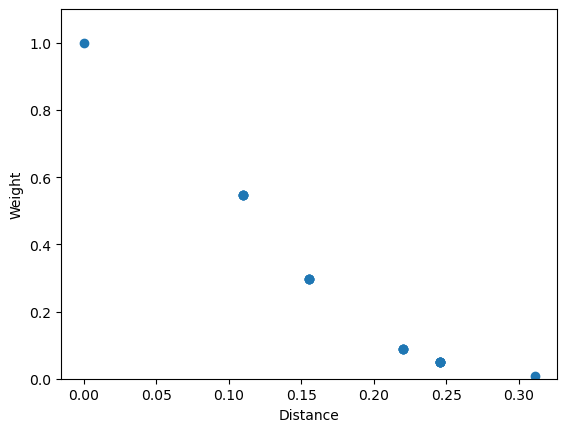

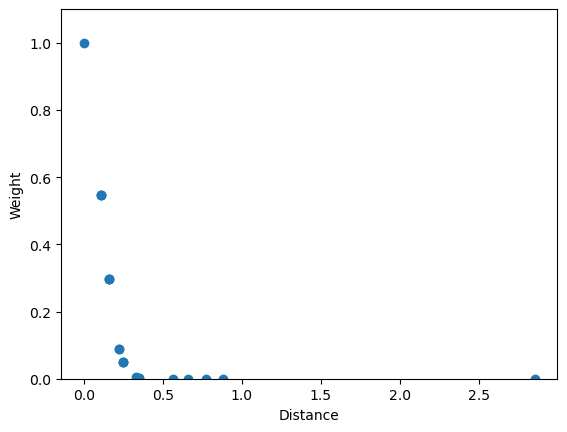

In [26]:
c=0.1

land_dist_deg = (np.sqrt(((target_lon_land - target_lon_land.mean("points"))**2 + \
        (target_lat_land - target_lat_land.mean("points"))**2)))
closest_land_lon = target_lon_land.isel(points=land_dist_deg.idxmin("points").astype(int))
closest_land_lat = target_lat_land.isel(points=land_dist_deg.idxmin("points").astype(int))
x_land = (np.sqrt(((target_lon_land - closest_land_lon)**2 + \
        (target_lat_land - closest_land_lat)**2)))
weights_land = np.exp(-(x_land**2/(2*c**2)))

sea_dist_deg = (np.sqrt(((target_lon_sea - target_lon_sea.mean("points"))**2 + \
        (target_lat_sea - target_lat_sea.mean("points"))**2)))
closest_sea_lon = target_lon_sea.isel(points=sea_dist_deg.idxmin("points").astype(int))
closest_sea_lat = target_lat_sea.isel(points=sea_dist_deg.idxmin("points").astype(int))
x_sea = (np.sqrt(((target_lon_sea - closest_sea_lon)**2 + \
        (target_lat_sea - closest_sea_lat)**2)))
weights_sea = np.exp(-(x_sea**2/(2*c**2)))


plt.plot(x_land.isel(lat=100,lon=100),weights_land.isel(lat=100,lon=100),marker="o",ls="none")
plt.ylabel("Weight")
plt.xlabel("Distance")
plt.ylim([0,1.1])

plt.figure()
plt.plot(x_land.isel(lat=43,lon=100),weights_land.isel(lat=43,lon=100),marker="o",ls="none")
plt.ylabel("Weight")
plt.xlabel("Distance")
plt.ylim([0,1.1])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


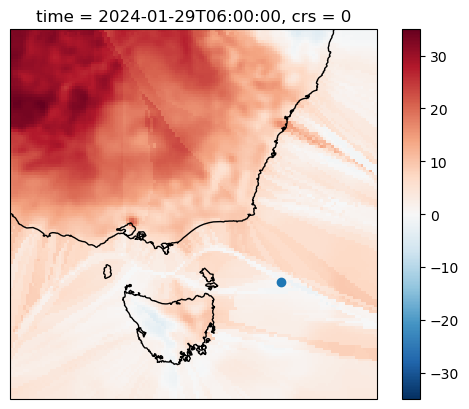

In [27]:
#Method 2: For each point calculate a weighted mean of the closest N land points and N sea points, and take the diff.
#Here, weights are defined using a gaussian filter (sigma=0.3)


# x_land = (np.sqrt(((target_lon_land - target_lon_land.mean("points"))**2 + \
#         (target_lat_land - target_lat_land.mean("points"))**2)))
# c=0.1

# weights_land = np.exp(-(x_land**2/(2*c**2)))

# x_sea = (np.sqrt(((target_lon_sea - target_lon_sea.mean("points"))**2 + \
#         (target_lat_sea - target_lat_sea.mean("points"))**2)))
# weights_sea = np.exp(-(x_sea**2/(2*c**2)))

land_minus_sea = ((barrar_vars["ts"]["ts"].sel(lon=target_lon_land,lat=target_lat_land) * weights_land).sum("points") / weights_land.sum("points")) - \
                    ((barrar_vars["ts"]["ts"].sel(lon=target_lon_sea,lat=target_lat_sea) * weights_sea).sum("points") / weights_sea.sum("points"))

ax=plt.axes(projection=ccrs.PlateCarree())
land_minus_sea.isel(time=6).plot()
ax.coastlines()

plt.plot(xx[43,100],yy[43,100],marker="o")

In [11]:
#Method 3: Can we repeat method 2 and then divide by distance from the coast? Then we would get a land-sea temp gradient in K/km

dist = np.zeros(xx.shape)
x_coast = xx[barrar_angles.coast==1]
y_coast = yy[barrar_angles.coast==1]
for i in tqdm.tqdm(np.arange(xx.shape[0])):
    for j in np.arange(xx.shape[1]):
        dist[i,j] = np.min(latlon_dist(yy[i,j],xx[i,j],y_coast,x_coast))

#Just use the closest point for this method
N = 1

_,land_ind = land_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, N)
target_lon_land = land_lon[land_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lat_land = land_lat[land_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lon_land = xr.DataArray(target_lon_land,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})
target_lat_land = xr.DataArray(target_lat_land,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})

_,sea_ind = sea_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, N)
target_lon_sea = sea_lon[sea_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lat_sea = sea_lat[sea_ind.reshape((lat.shape[0],lon.shape[0],-1))]
target_lon_sea = xr.DataArray(target_lon_sea,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})
target_lat_sea = xr.DataArray(target_lat_sea,dims=("lat","lon","points"),coords={"lat":lsm.lat,"lon":lsm.lon,"points":np.arange(N)})

100%|██████████| 137/137 [00:01<00:00, 79.24it/s]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Gradient in closest land temperature minus\nclosest ocean temperatures')

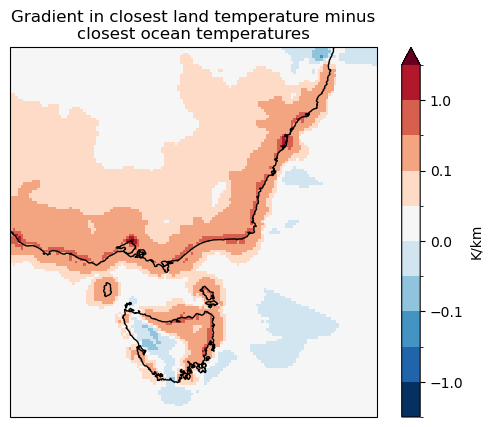

In [13]:
ax=plt.axes(projection=ccrs.PlateCarree())

dx=12

c=xr.where(dist==0,
         land_minus_sea.isel(time=6) / dx,
         (land_minus_sea.isel(time=6) / dist)).plot(levels=[-2,-1,-0.5,-0.1,-0.05,0,0.05,0.1,0.5,1,2],add_colorbar=False)
ax.coastlines()
cb=plt.colorbar(c)
cb.set_label("K/km")

plt.title("Gradient in closest land temperature minus\nclosest ocean temperatures")

10953.022328353698 <Unit('meter')>

In [48]:
xx.shape

(137, 136)

In [47]:
np.pad(dx.shape

(137, 135)